# Data Analysis of DFT calculations from VASP

Here is an example of the data processing procedure applied in Zanetta et al,. 2022

Do not hesitate to contact the author via Github or directly by email (Pierre.marie.zanetta@gmail.com).

## Author 

24/06/2022 Pierre-marie Zanetta # released 01/09/2022

## requirements

spglib, vaspy and pymatgen

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import spglib as spg
import vaspy
from vaspy.iter import OutCar
from vaspy.iter import PosCar

# Table of contents:
* [1. Symmetry estimation](#first-bullet)
* [2. Force evaluation on M4 site](#second-bullet)
* [3. Distance determination between central atoms and bonded O¶](#third-bullet)
* [4. Read vasprun.xml and extract the band structure](#fourth-bullet)

## 1. Symmetry estimation<a class="anchor" id="first-bullet"></a>

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
dirName = 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/';
# Get the list of all files in directory tree at given path
listOfFiles = getListOfFiles(dirName)

In [4]:
cont=[]
for file in listOfFiles:
        if file.endswith("CONTCAR"):
            cont.append(file)
        elif file.endswith("CONTCAR.01"):
            cont.append(file)
        elif file.endswith("CONTCAR.02"):
            cont.append(file)
        elif file.endswith("CONTCAR.03"):
            cont.append(file)

In [5]:
cont.reverse()
cont.reverse()
cont

['TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\CONTCAR.01',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\CONTCAR.01',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_221\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_442\\CONTCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_442\\for_chgcar\\CONTCAR']

In [6]:
init=[]
for file in listOfFiles:
    if file.endswith("POSCAR"):
        init.append(file)

In [7]:
init

['TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_221\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_442\\for_chgcar\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_442\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\POSCAR',
 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/POSCAR']

In [8]:
init=PosCar(init[-1])

In [9]:
for i in range (0,len(cont)-3):
    # read the structural info for all files
    cont1= PosCar(cont[i])
    lattice=cont1.bases
    positions=cont1.data
    numbers=[]
    atom=[]
    
    ### create a list with the atom numbers (refer to the contcar file 1 is Al, 2 is Ca etc. Alphabetically)
    for j in range (0, len(cont1.atom_numbers)):
        for k in range (0,cont1.atom_numbers[j]):
            numbers.append(j+1)
            atom.append(cont1.atom_types[j])
    ## replace all Ti and Mg with Al (Mg and Ti are the number 3 and 5 alphabatically)
    for j in range (0,len (numbers)):
        if numbers[j]==3:
            numbers[j]=1
        if numbers[j]==5:
            numbers[j]=1
            
        variation=abs(init.data-positions)
    
        mask=variation >0.9
                
        positions[mask]=positions[mask]-1
                
        variation[:,0]=variation[:,0]*lattice[0,0]
        variation[:,1]=variation[:,1]*lattice[0,0]
        variation[:,2]=variation[:,2]*lattice[2,2]

        
   
#     positions=np.delete(positions,slice(152,200),0) # remove O4 Wickoff site
#     numbers=np.delete(numbers,slice(152,200),0)  #remove O4 Wickoff site
#     atom=np.delete(atom,slice(152,200),0)  #remove O4 Wickoff site
    


#     positions=np.delete(positions,slice(88,240),0) # remove O
#     numbers=np.delete(numbers,slice(88,240),0)  #remove O
#     atom=np.delete(atom,slice(88,240),0)  #remove O
    
#     positions=np.delete(positions,slice(64,72),0) # remove Ca Wickoff site
#     numbers=np.delete(numbers,slice(64,72),0)  #remove Ca Wickoff site
#     atom=np.delete(atom,slice(64,72),0)  #remove Ca Wickoff site
    
#     positions=np.delete(positions,slice(240,248),0) # remove Al2 Wickoff site
#     numbers=np.delete(numbers,slice(240,248),0)  #remove Al2 Wickoff site
#     atom=np.delete(atom,slice(240,248),0)  #remove Al2 Wickoff site
    
    
    cell=(lattice,positions,numbers)
    ### find the primitive cell (pass from supercell to unique cell)
    cell2=spg.find_primitive(cell,symprec=1e-2)
    spacegroup = spg.get_spacegroup(cell2, symprec=0.97)
    #cell3= do average of atomic positions
#     spacegroup = spg.get_spacegroup(cell2, symprec=1e-1)
    print (spacegroup)
    print(i)

P6_3/mmc (194)
0
P6_3/mmc (194)
1
P6_3/mmc (194)
2
P6_3/mmc (194)
3
P6_3/mmc (194)
4
P6_3/mmc (194)
5
P6_3/mmc (194)
6
P6_3/mmc (194)
7


In [10]:
atoml=list(atom)
print(atoml.index('Ca'))
print(atoml.index('Mg'))
print(atoml.index('O'))
print(atoml.index('Ti'))

64
72
88
240


In [11]:
mask=variation<0.9
np.max(variation[mask])
variation[~mask]=0

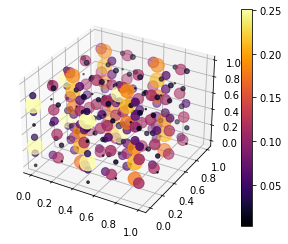

In [12]:
from mpl_toolkits import mplot3d


fig = plt.figure()
# ax = fig.add_subplot(2, 2, 1, projection='3d')

# # ax = plt.axes(projection='3d')
# p=ax.scatter3D(positions[:,0],positions[:,1], positions[:,2], s=variation[:,0]*1000 , c=variation[:,0], cmap='inferno');
# fig.colorbar(p)

# ax = fig.add_subplot(2, 2, 2, projection='3d')
# p=ax.scatter3D(positions[:,0],positions[:,1], positions[:,2], s=variation[:,1]*1000 , c=variation[:,1], cmap='inferno');
# fig.colorbar(p)

ax = fig.add_subplot(1, 1, 1, projection='3d')

p=ax.scatter3D(positions[:,0],positions[:,1], positions[:,2], s=variation[:,2]*1000 , c=variation[:,2], cmap='inferno');
fig.colorbar(p)

## 2. Force evaluation on M4 site<a class="anchor" id="second-bullet"></a>

In [13]:
cd "TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7/""

C:\Users\Pierre-Marie\Documents\GitHub\DFT-Crystal-structure-evaluation\TiAl4fullMgAl3full\4atomsMgTionAl3Al4\ISIF7


In [14]:
poscar = PosCar('POSCAR')
outcar = OutCar('OUTCAR')

In [15]:
a=poscar.bases[1][1]
c=poscar.bases[2][2]

In [16]:
zdisp=0.25*c
zdisp2=0.75*c

In [17]:
c=[]
fo=[]
for f in outcar.iforces:
    c.append(f.coordinates)
    fo.append(f.forces)

In [18]:
p1=[]
p2=[]
p3=[]
p4=[]
f1=[]
f2=[]
f3=[]
f4=[]
step=[]

for i in range (0,len(c)):
    step.append(i)
    p1.append((c[i][8:12][0][2]))
    p2.append((c[i][8:12][1][2]))
    p3.append((c[i][8:12][2][2]))
    p4.append((c[i][8:12][3][2]))
    f1.append((fo[i][8:12][0][2]))
    f2.append((fo[i][8:12][1][2]))
    f3.append((fo[i][8:12][2][2]))
    f4.append((fo[i][8:12][3][2]))

Text(0.5, 0, 'steps')

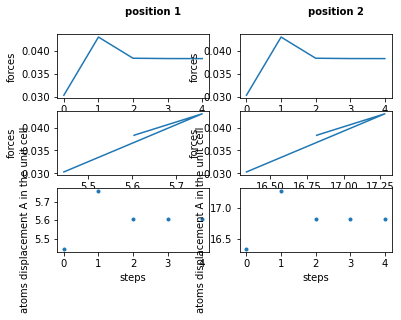

In [19]:
fig=plt.figure()
ax1=plt.subplot(321)
plt.plot(step,f1,'-')
plt.text(0.45, 1.3, "position 1", fontweight="bold", transform=ax1.transAxes)
plt.xlabel('steps')
plt.ylabel('forces')
plt.subplot(323)
plt.plot(p1,f1,'-')
plt.xlabel('atoms displacement A')
plt.ylabel('forces')
ax2=plt.subplot(322)
plt.plot(step,f2,'-')
plt.text(0.45, 1.3, "position 2", fontweight="bold", transform=ax2.transAxes)
plt.xlabel('steps')
plt.ylabel('forces')
plt.subplot(324)
plt.plot(p2,f2,'-')
plt.xlabel('atoms displacement A')
plt.ylabel('forces')
plt.subplot(325)
plt.plot(step,p1,'.')
plt.ylabel('atoms displacement A in the unit cell')
plt.xlabel('steps')
plt.subplot(326)
plt.plot(step,p2,'.')
plt.ylabel('atoms displacement A in the unit cell')
plt.xlabel('steps')


In [20]:
totdisp=[]
totdisp=p1
totdisp.extend(p2)
totf=[]
totf=f1
totf.extend(f2)

Text(0.5, 1.0, 'force vs step')

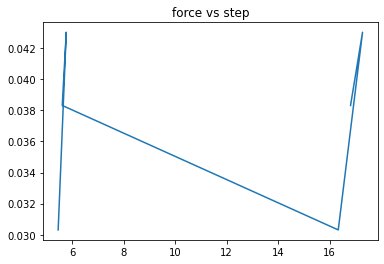

In [21]:
plt.figure()
plt.plot(totdisp,totf,'-')
plt.title('force vs step')

## 3. Distance determination between central atoms and bonded O<a class="anchor" id="third-bullet"></a>

In [22]:
from pymatgen.core import Lattice, Structure
from pymatgen.analysis import local_env

In [23]:
import glob

In [24]:
cd TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISIF7\\ISIF2\\ISMEAR_-5_kmesh_442\

[WinError 3] The system cannot find the path specified: 'TiAl4fullMgAl3full/4atomsMgTionAl3Al4/ISIF7\\\\ISIF2\\\\ISIF7\\\\ISIF2\\\\ISIF7\\\\ISIF2\\\\ISMEAR_-5_kmesh_442\\'
C:\Users\Pierre-Marie\Documents\GitHub\DFT-Crystal-structure-evaluation\TiAl4fullMgAl3full\4atomsMgTionAl3Al4\ISIF7


In [25]:
targetPattern = r"Contcar"
cell=Structure.from_file(glob.glob(targetPattern)[0])

In [26]:
cell

Structure Summary
Lattice
    abc : 11.465310230306784 11.465310230276426 22.419978872421183
 angles : 90.0 90.0 120.0000000000876
 volume : 2552.3336812311786
      A : 11.465310230306784 0.0 0.0
      B : -5.732655115153392 9.929249921680233 0.0
      C : 0.0 0.0 22.419978872421183
PeriodicSite: Al (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Al (0.0000, 0.0000, 11.2100) [0.0000, 0.0000, 0.5000]
PeriodicSite: Al (8.5990, 4.9646, 0.0000) [1.0000, 0.5000, 0.0000]
PeriodicSite: Al (8.5990, 4.9646, 11.2100) [1.0000, 0.5000, 0.5000]
PeriodicSite: Al (5.7327, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: Al (5.7327, 0.0000, 11.2100) [0.5000, 0.0000, 0.5000]
PeriodicSite: Al (2.8663, 4.9646, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Al (2.8663, 4.9646, 11.2100) [0.5000, 0.5000, 0.5000]
PeriodicSite: Al (0.0000, 0.0000, 5.6050) [0.0000, 0.0000, 0.2500]
PeriodicSite: Al (0.0000, 0.0000, 16.8150) [0.0000, 0.0000, 0.7500]
PeriodicSite: Al (8.5990, 4.9646, 5.6050

In [27]:
#average bond distance of the AL2 site via the average of distance from the nearest neighbors
coordination=5 #coordination of Al2
average=np.zeros([1,coordination])
for u in range (4,4+4):#Al2 in the list
    atomind=u
    x=[]
    y=cell.get_neighbors(cell.sites[atomind],5)
    for i in range (0,len(y)):
        x.append(cell.sites[atomind].distance(y[i]))
    x.sort()
    print(x[0:coordination])
    x=np.array(x)                
    average += x[0:coordination]
average=average/5
print(average)

[1.9421818669128743, 1.942182040947982, 1.9421821265597765, 1.94218220524488, 1.94218222978121]
[1.9421818669128732, 1.9421818905174113, 1.9421820793506541, 1.9421821265597754, 1.942182205244879]
[1.9421818363719143, 1.942181874781089, 1.9421820252116604, 1.9421820321447612, 1.9421820793507096]
[1.942181685941328, 1.9421818747810882, 1.9421818747810884, 1.94218203214476, 1.942182032144762]
[[1.55374545 1.55374554 1.55374562 1.55374568 1.55374571]]


## 4) Read vasprun.xml and extract the band structure<a class="anchor" id="fourth-bullet"></a>

#### This part is actually not running online because of the size of the vasprun.xml files that could not get loaded on github

In [ ]:
import pymatgen as mg
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.plotter import BSPlotter, BSDOSPlotter, DosPlotter

In [ ]:
run = BSVasprun("vasprun.xml", parse_projected_eigen=True)

In [ ]:
bs = run.get_band_structure("KPOINTS")

In [ ]:
bs = run.get_band_structure("KPOINTS")

In [ ]:
print("number of bands", bs.nb_bands)

In [ ]:
print("number of kpoints", len(bs.kpoints))

In [ ]:
bs.is_metal()

In [ ]:
bs.is_spin_polarized

### 4.1) Extract a given band or eigenvalues

In [ ]:
bs.bands

In [ ]:
bs.bands[Spin.up].shape

In [ ]:
bs.bands[Spin.down][9, :]

In [ ]:
n = 0
for kpoints, e in zip(bs.kpoints, bs.bands[Spin.down][9, :]):
    n += 1
    if n == 11:
        print("...")
    if 10 < n < 190:
        continue

    print("kx = %5.3f  ky = %5.3f  kz = %5.3f   eps(k) = %8.4f" % (tuple(kpoints.frac_coords) +  (e,)))

In [ ]:
bsplot = BSPlotter(bs)

In [ ]:
bsplot = BSPlotter(bs)

In [ ]:
# get the plot
bsplot.get_plot(ylim=(-20, 10), zero_to_efermi=True)
print(bs.efermi)

# add some features
ax = plt.gca()
ax.set_title("NiO Band Structure", fontsize=20)
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], linestyles="dashed", color="black")

# add legend
ax.plot((), (), "b-", label="spin up")
ax.plot((), (), "r--", label="spin down")
ax.legend(fontsize=16, loc="upper left")

### 4.2) Extract data from the plot

In [ ]:
data = bsplot.bs_plot_data()

In [ ]:
data.keys()

In [ ]:
ibands = 9  # band number from 0 --> number of bands
spin = str(Spin.up)

for xpath, epath in zip(data["distances"], data["energy"]):
    print(20 * "-")
    for x, bands in zip(xpath, epath[spin][ibands]):
        print("%8.4f %8.4f" % (x, bands))

In [ ]:
ibands = 9  # band number from 0 --> number of bands
spin = str(Spin.up)

for xpath, epath in zip(data["distances"], data["energy"]):
    plt.plot(xpath, epath[spin][ibands])

In [ ]:
ibands = 1  # band number from 0 --> number of bands
spin = str(Spin.up)

x = list()
y = list()
for xpath, epath in zip(data["distances"], data["energy"]):
    x += xpath
    y += epath[spin][ibands]

plt.plot(x, y)

### 4.3) Plot DOS

In [ ]:
dosrun = Vasprun("vasprun.xml", parse_dos=True)
dos = dosrun.complete_dos
print(dosrun.efermi)
print(dos.efermi)

In [ ]:
dosplot = DosPlotter(sigma=0.1)
dosplot.add_dos("Total DOS", dos)
dosplot.add_dos_dict(dos.get_element_dos())
plt = dosplot.get_plot()
plt.grid()

In [ ]:
# 5) Plot Bands and DOS

In [ ]:
bs = run.get_band_structure("KPOINTS", efermi=dos.efermi)

In [ ]:
bsdosplot = BSDOSPlotter(
    bs_projection="elements", 
    dos_projection="elements", 
    vb_energy_range=22,
    egrid_interval=2.5
)
plt = bsdosplot.get_plot(bs, dos=dos)

In [ ]:
bsdosplot = BSDOSPlotter(
    bs_projection="elements", 
    dos_projection="elements", 
    vb_energy_range=11,
    cb_energy_range=10,
    egrid_interval=2
)
plt = bsdosplot.get_plot(bs, dos=dos)